In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/leaf_classification
import sys
sys.path.append('/content/drive/MyDrive/leaf_classification')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ClassificationModel.py		  Grapevine_Leaves_Image_Dataset  __pycache__
Collab_leaf_classification.ipynb  importLibrary.py


In [ ]:
from importLibrary import *
import ClassificationModel as CM

In [ ]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [ ]:
seed = 121  # You can use any integer value as the seed
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
all_data = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/leaf_classification/Grapevine_Leaves_Image_Dataset',
    labels='inferred',
    label_mode='categorical',  # etichette one-hot
    image_size=IMG_SIZE,  # ad esempio (224, 224)
    batch_size=None,  # nessun batch, ottieni tutte le immagini una per una
    shuffle=True,               # Mescola le immagini randomicamente
    seed=42                     # Fissa il seed per rendere il risultato riproducibile
)

## All Data Normalization
all_data = all_data.map(lambda x, y: (x / 255.0, y))

# Estrai le immagini e le etichette dal dataset
image_list = []
label_list = []

for image, label in all_data:
    image_list.append(image.numpy())  # Converti l'immagine in NumPy array
    label_list.append(label.numpy())  # Converti l'etichetta in NumPy array

# Converti le liste in array NumPy
image_array = np.array(image_list)
label_array = np.array(label_list)

print(f"image_array.shape: {image_array.shape}")
print(f"label_array.shape: {label_array.shape}")

# Primo split: ottieni training (70%) e temp (30%) per test+validation
X_train, X_temp, y_train, y_temp = train_test_split(
    image_array, label_array, test_size=0.3, stratify=label_array, random_state=seed  # 30% per validation+test
)

# Secondo split: dividi temp in validation (10%) e test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.66, stratify=y_temp, random_state=seed  # 2/3 per test, 1/3 per validation
)

# Convertire i dati divisi in tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))#.batch(BATCH_SIZE)
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))#.batch(BATCH_SIZE)


Found 500 files belonging to 5 classes.
image_array.shape: (500, 256, 256, 3)
label_array.shape: (500, 5)


350
(256, 256, 3)
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


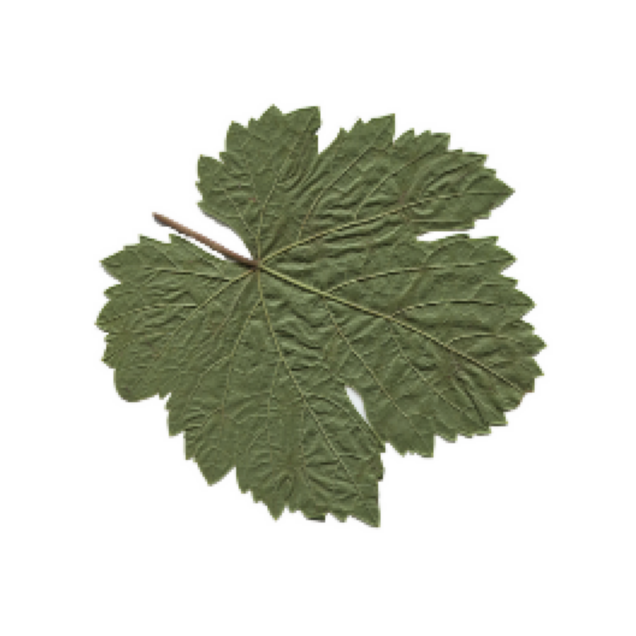

In [ ]:
print(train_data.cardinality().numpy()) #num BATCH
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch) # contiene one-hot delle classi
    break

img = image_batch[:,:,:].numpy()#.astype(np.uint8) <-- se non normalizzata mettere

# Crea una figura e un'asse
plt.figure(figsize=(8, 8))  # Puoi regolare le dimensioni della figura
plt.imshow(img)  # Mostra l'immagine
plt.axis('off')  # Disabilita gli assi
plt.show()  # Mostra la figura

In [ ]:
# Define a function for data augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip the image
    # image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change brightness
    # image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Randomly adjust contrast
    return image, label

def random_rotate_image(image, label):
    # Scegliamo casualmente tra 1 (90 gradi), 2 (180 gradi) e 3 (270 gradi)
    k = np.random.choice([1, 2, 3])
    return tf.image.rot90(image, k=k), label

# Apply the augmentation function
augmented_data = train_data.map(random_rotate_image)

350
(256, 256, 3)


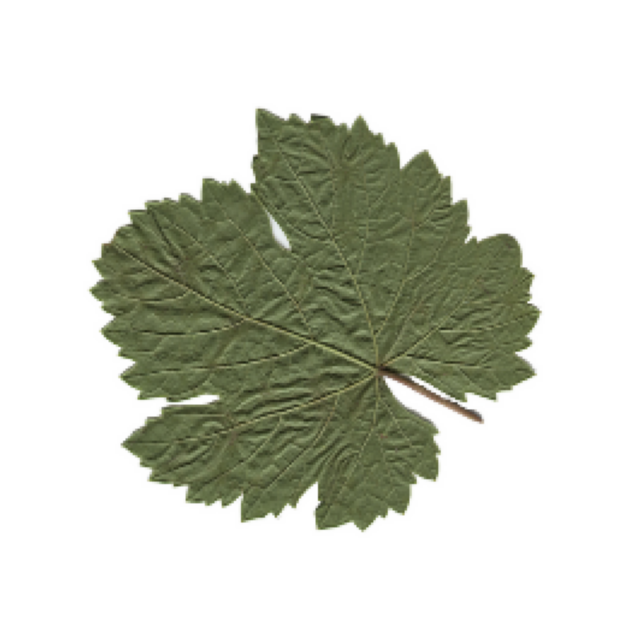

In [ ]:
# Converte il dataset in un iteratore numpy
augmented_image, augmented_label = [], []
for images, labels in augmented_data.as_numpy_iterator():
    augmented_image.append(images)
    augmented_label.append(labels)

print(len(augmented_image))
print(augmented_image[0].shape)

img = augmented_image[0]#.astype(np.uint8)
# Converti l'immagine da BGR a RGB (OpenCV usa BGR per default)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crea una figura e un'asse
plt.figure(figsize=(8, 8))  # Puoi regolare le dimensioni della figura
plt.imshow(img)  # Mostra l'immagine
plt.axis('off')  # Disabilita gli assi
plt.show()  # Mostra la figura

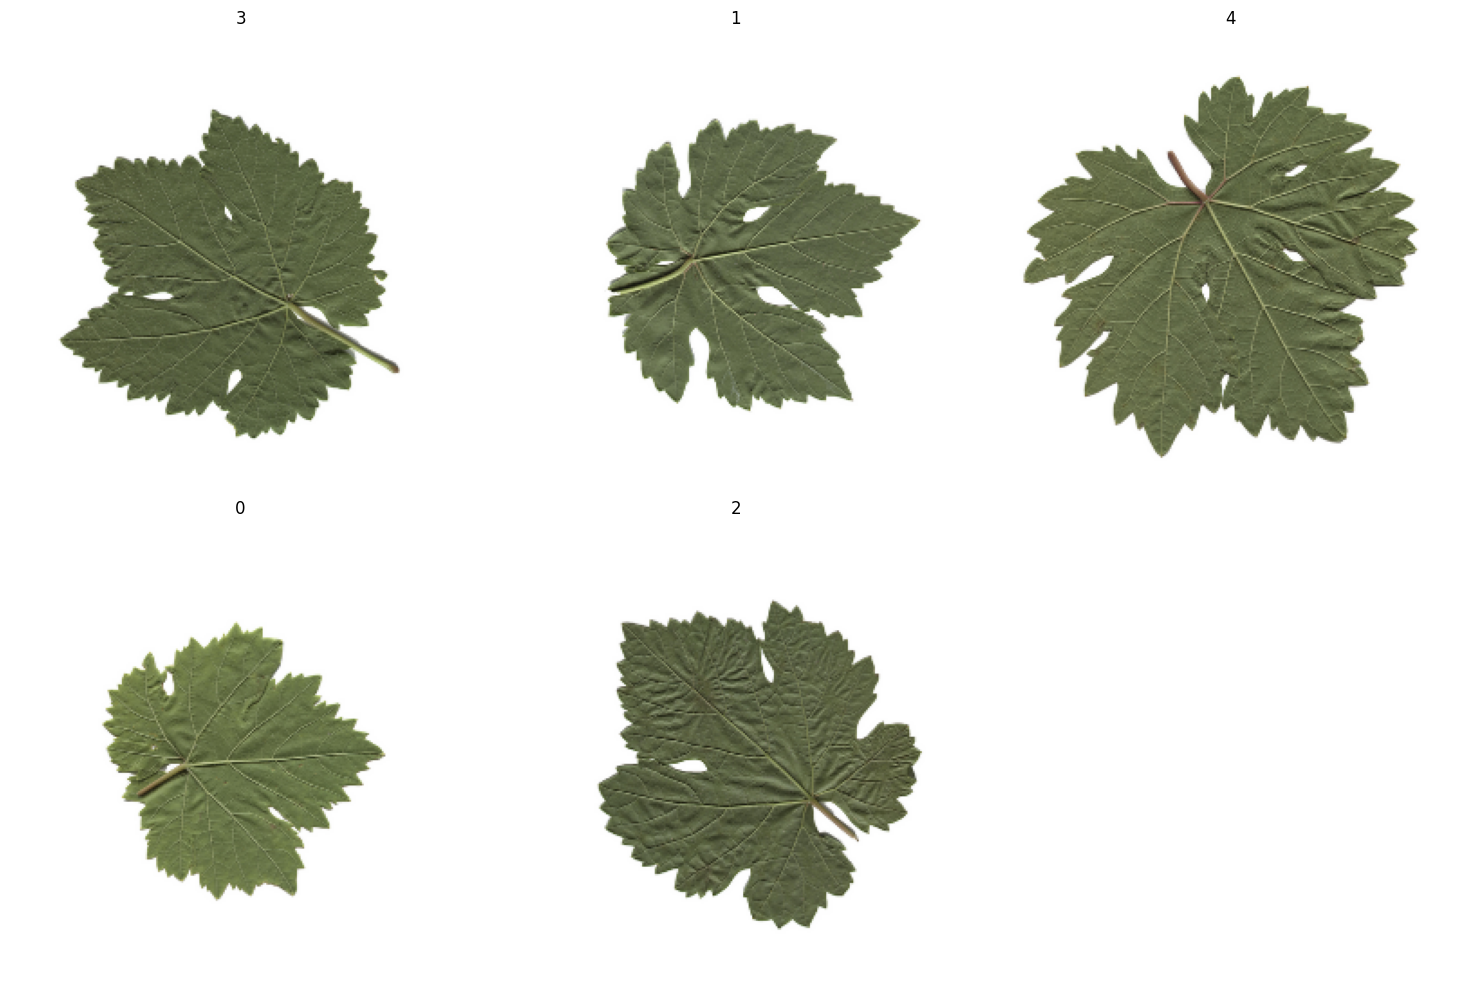

700
[[140. 140. 140. 140. 140.]]


In [ ]:
# combined_data = train_data #.unbatch() <-- per annullare il .batch

## scommentare se voglio unire anche augmented data al training set ##
# Combiniamo i due dataset (originale e aumentato)
combined_data = train_data.concatenate(augmented_data)

# Optional: Shuffling e batching del nuovo dataset esteso
combined_data = combined_data.shuffle(buffer_size=1024).batch(BATCH_SIZE)
size = 0
num_class_elem = np.zeros((1,5))
IMG = []
LABEL_IMG = []
for i in combined_data:
    img,l = i
    size += img.shape[0]
    num_class_elem += np.sum(l, axis=0)

    for index, label in enumerate(l):
        idx = np.argmax(label)
        if idx not in LABEL_IMG:
            IMG.append(img[index])
            LABEL_IMG.append(idx)
        if len(LABEL_IMG)==5:
            break

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(5):
    ax = axs[i // 3, i % 3]
    ax.imshow(IMG[i])
    ax.axis('off')
    ax.set_title(LABEL_IMG[i])

ax = axs[1, 2]
ax.axis('off')

plt.tight_layout()
plt.show()

print(size)
print(num_class_elem)

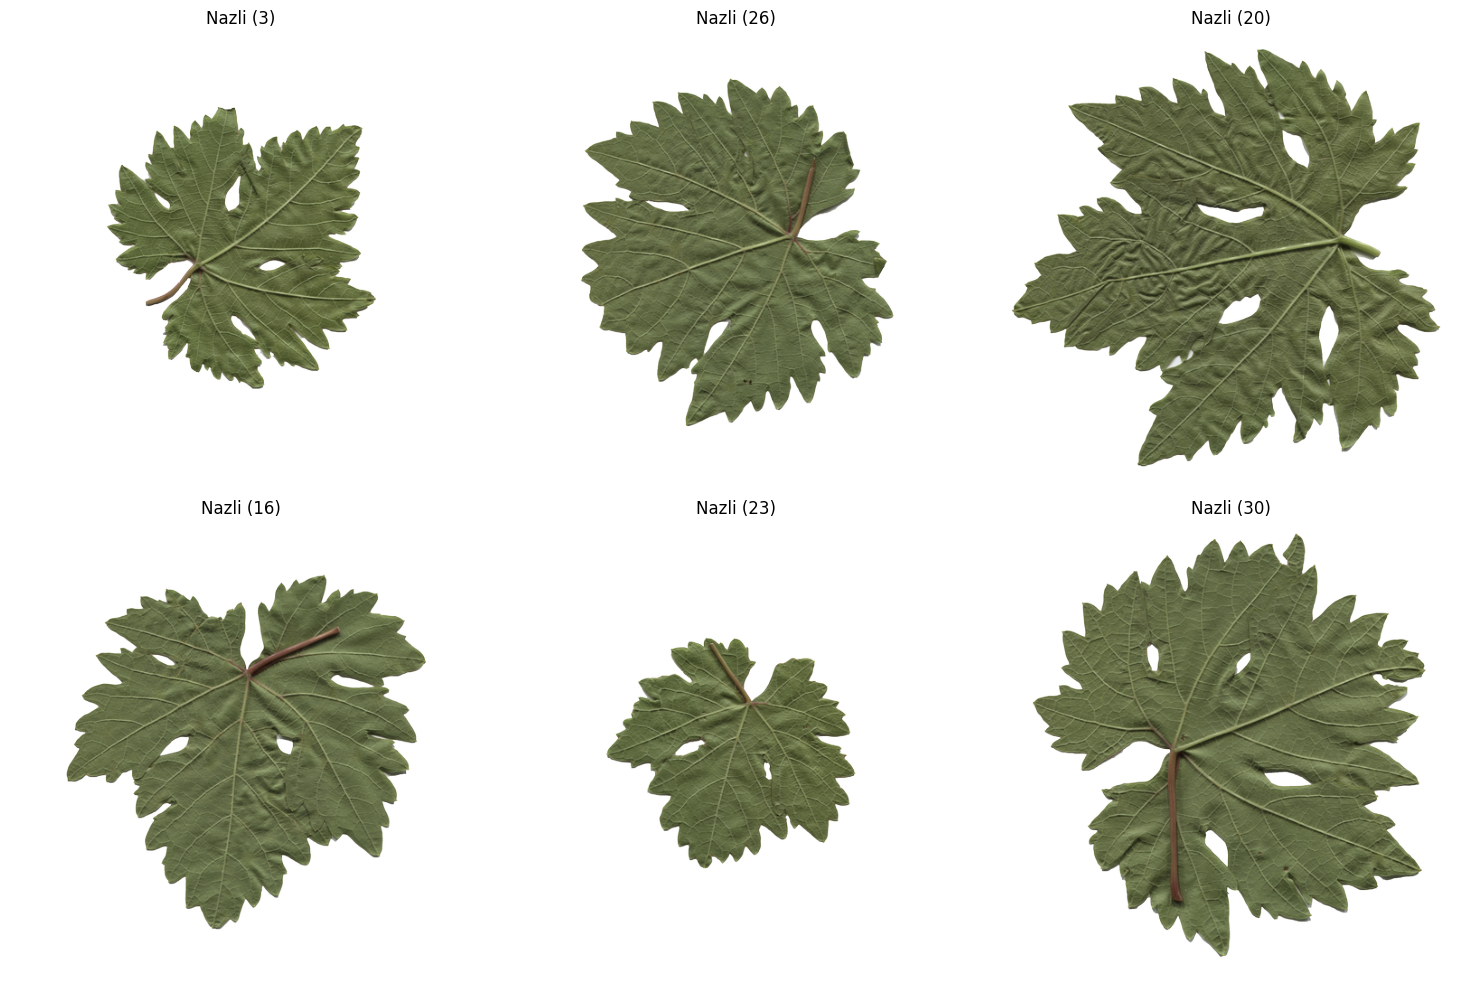

In [ ]:
# Path to the directory containing images
path = "/content/drive/MyDrive/leaf_classification/Grapevine_Leaves_Image_Dataset/Nazli"
# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [ ]:
num_classes = y_train.shape[1]
# n = "resNet_fineTuned_"
n = "VGG16_finetuned_"
# n = "CNN_"
if n=="resNet_fineTuned_":
    model = CM.GenerateResModel(num_classes)
elif n=="CNN_":
    model = CM.GenerateCNN(num_classes)
elif n=="VGG16_finetuned_":
    model = CM.GenerateVGG16Model(num_classes)
elif n=="VGG19_finetuned_":
    model = CM.GenerateVGG19Model(num_classes)
else:
    print("not implemented")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,143,701 (88.29 MB)

 Trainable params: 15,507,565 (59.16 MB)

 Non-trainable params: 7,636,136 (29.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Imposta il callback di Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric da monitorare (ad esempio la perdita sul validation set)
    patience=5,                # Numero di epoche di pazienza (ad esempio, 5)
    restore_best_weights=True  # Ripristina i pesi con le migliori prestazioni sul validation set
)

def TrainModel(model: Model, alpha: float = 0.0001, epochs: int = 20):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=alpha), metrics=['categorical_accuracy'])
    #train_d = train_data.batch(BATCH_SIZE)

    history = model.fit(
        combined_data,
        epochs=epochs,
        verbose=1,
        validation_data=validation_data,  # Batch di validazione separato con dimensione diversa
        callbacks=[early_stopping]
    )
    return history

In [ ]:
history = TrainModel(model, alpha=0.0001, epochs=50)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.2021 - loss: 1.8348 - val_categorical_accuracy: 0.2157 - val_loss: 1.6039
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - categorical_accuracy: 0.2509 - loss: 1.7039 - val_categorical_accuracy: 0.2157 - val_loss: 2.0319
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - categorical_accuracy: 0.3474 - loss: 1.5250 - val_categorical_accuracy: 0.2353 - val_loss: 1.7887
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - categorical_accuracy: 0.4343 - loss: 1.3027 - val_categorical_accuracy: 0.3725 - val_loss: 1.5169
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - categorical_accuracy: 0.5448 - loss: 1.1395 - val_categorical_accuracy: 0.5098 - val_loss: 1.2289
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - categorical_accuracy: 0.5999 - loss: 1.0344 - val_categorical_accuracy: 0.6078 - val_loss: 1.1397
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - categorical_accuracy: 0.6960 - loss

# Test Model

In [ ]:
def PlotHistory(history) -> None:
    # Plot training & validation accuracy values
    plt.plot(history.history['categorical_accuracy'], label='train accuracy') #categorical_accuracy
    # plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='train loss')
    # plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

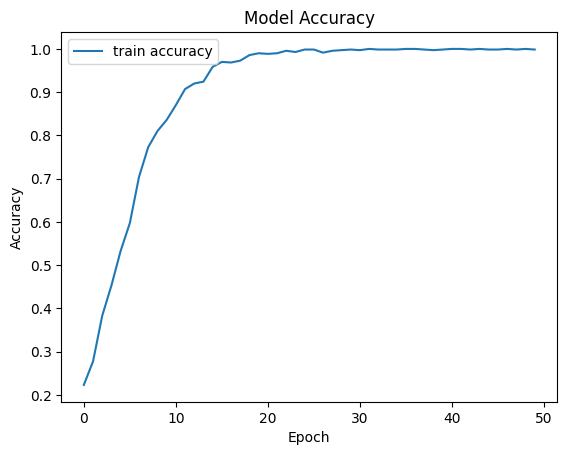

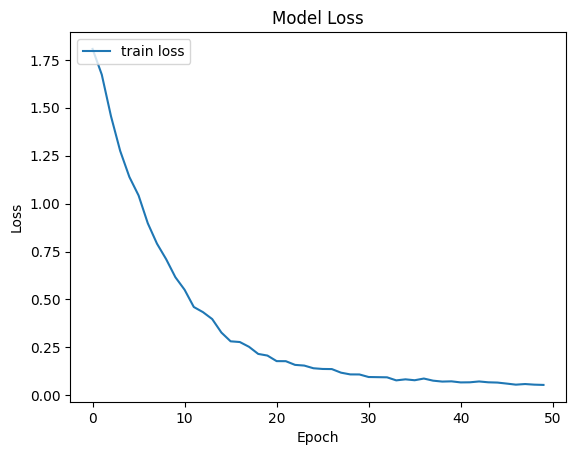

In [ ]:
PlotHistory(history)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

def PlotMetrics(max_indices_val, max_indices_pred):
    # Create the confusion matrix
    nn_cm = confusion_matrix(max_indices_val, max_indices_pred)
    accuracy = accuracy_score(max_indices_val, max_indices_pred)
    precision = precision_score(max_indices_val, max_indices_pred, average='macro')
    recall = recall_score(max_indices_val, max_indices_pred, average='macro')
    f1 = f1_score(max_indices_val, max_indices_pred, average='macro')

    print(nn_cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

print(X_train.shape)
print(np.max(X_train[0,:,:,0]))
y_pred = model.predict(X_train)
# print(y_pred[0:10])

max_indices_pred = np.argmax(y_pred, axis=1) #prediction as class number
# print(max_indices_pred[0:10])
max_indices_val = np.argmax(y_train, axis=1) #prediction as class number
# print(max_indices_val[0:10])

PlotMetrics(max_indices_val, max_indices_pred)

(350, 256, 256, 3)
1.0
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
[[70  0  0  0  0]
 [ 0 70  0  0  0]
 [ 0  0 70  0  0]
 [ 0  0  0 70  0]
 [ 0  0  0  0 70]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [ ]:
y_pred = model.predict(X_test)
# print(y_pred)
# print(y_test)
max_indices_pred = np.argmax(y_pred, axis=1) #prediction as class number
max_indices_val = np.argmax(y_test, axis=1) #prediction as class number

PlotMetrics(max_indices_val, max_indices_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
[[19  0  0  0  0]
 [ 2 17  1  0  0]
 [ 4  0 16  0  0]
 [ 2  0  0 18  0]
 [ 2  0  0  0 18]]
Accuracy: 0.8888888888888888
Precision: 0.9192697768762678
Recall: 0.89
F1 Score: 0.8940374585111426
